<a href="https://colab.research.google.com/github/jiananwu72/LuFeO3Detect/blob/main/LuFeO3/LFOWindowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyNSID sidpy atomap nanonispy gwyfile pyTEMlib wget ipympl importlib
!pip install numpy==1.26.4

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


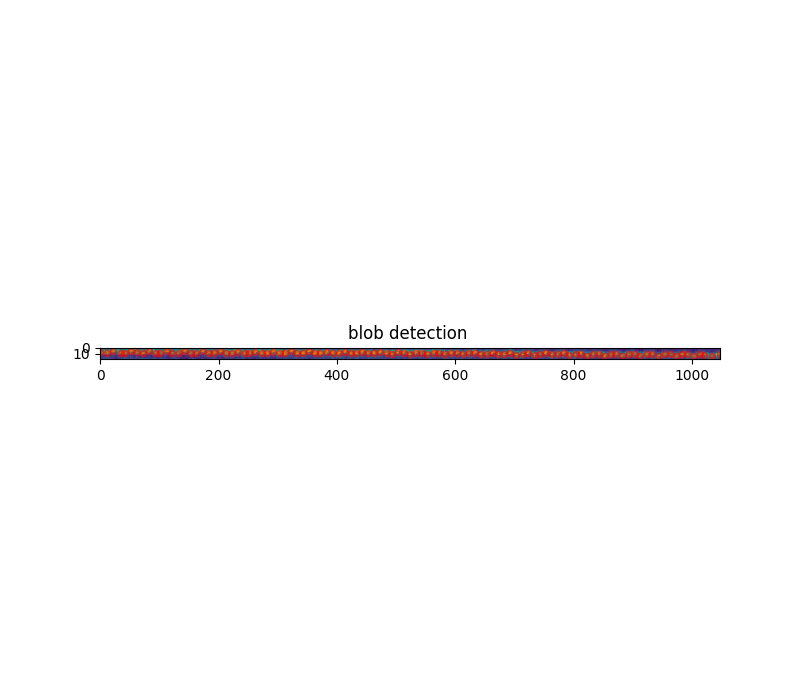

In [94]:
import skimage
import hyperspy.api as hs

threshold = 3e-7 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = 0.07 #in nm
min_atom_size = 0.02 #in nm
s = hs.load('/content/drive/MyDrive/Data/LFO/ITO LuFeO3_0029.dm3')
s_cropped = s.isig[500:-500, 725:745]

image = s_cropped

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")
plt.imshow(image, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))

# coordinates = skimage.feature.peak_local_max(image.data, min_distance=3)
# plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r', s=20, alpha = .5);

scale_x =image.axes_manager['x'].scale
blobs = skimage.feature.blob_log(image, min_sigma = min_atom_size/scale_x, max_sigma=atom_size/scale_x, threshold=threshold)
plt.scatter(blobs[:, 1], blobs[:, 0], c='r', s=20, alpha = .5);


In [95]:
import pyTEMlib.atom_tools
atom_radius = 3

sym = pyTEMlib.atom_tools.atom_refine(np.array(s_cropped), blobs, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

using radius  3 pixels


  0%|          | 0/105 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pyTEMlib/probe_tools.py:17: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


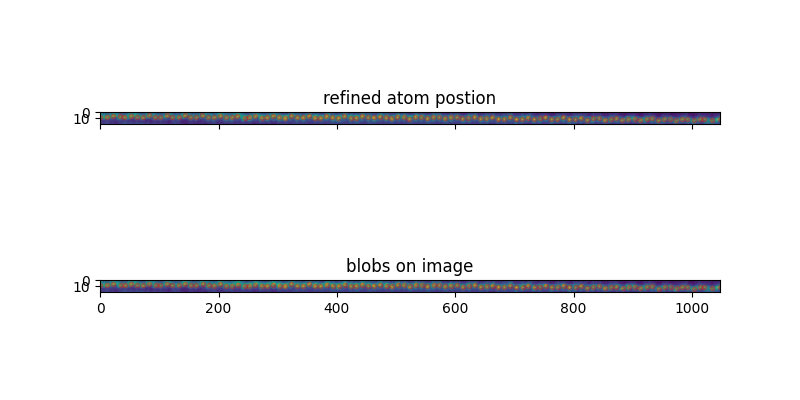

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,1],refined_atoms[:,0],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(blobs[:, 1], blobs[:, 0], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [98]:
atoms = refined_atoms[refined_atoms[:, 1].argsort()]
# atoms = atoms[:-1] #temporary fix

imagearr = np.array(image)
H, W = imagearr.shape

radius = 2

# Prepare a list to collect all 3×3 patches and keep track of valid indices
patches = []
valid_indices = []
masked_atoms = atoms

for idx in range(atoms.shape[0]):
    y, x = atoms[idx]
    cx = int(round(x))
    cy = int(round(y))

    if (cx - radius < 0) or (cy - radius < 0) or (cx + radius >= W) or (cy + radius >= H):
        mask = ~((masked_atoms[:,0] == y) & (masked_atoms[:,1] == x))
        masked_atoms = masked_atoms[mask]
        continue

    patch = imagearr[cy - radius : cy + radius + 1,
                     cx - radius : cx + radius + 1]

    patches.append(patch)
    valid_indices.append(idx)

# Convert the list of patches into a single NumPy array of shape (N_valid, 3, 3)
if len(patches) > 0:
    patches_array = np.stack(patches)
else:
    patches_array = np.empty((0, radius*2 + 1, radius*2 + 1))

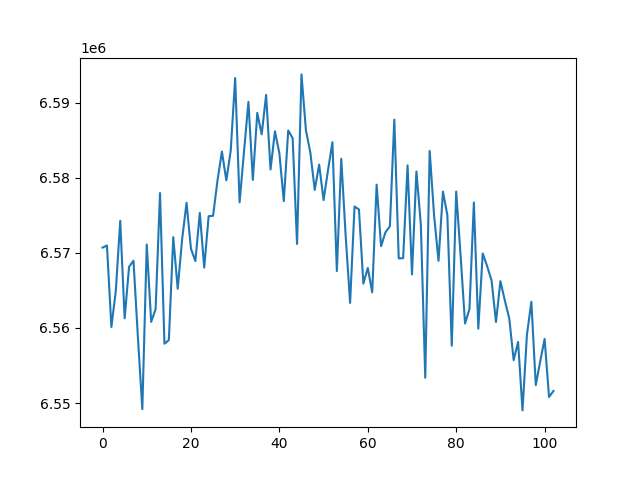

In [99]:
sums = []
for i in range(len(patches_array)):
    sums.append(np.sum(np.array(patches_array[i])))

plt.figure()
# plt.hist(sums, bins=20);
plt.plot(sums);

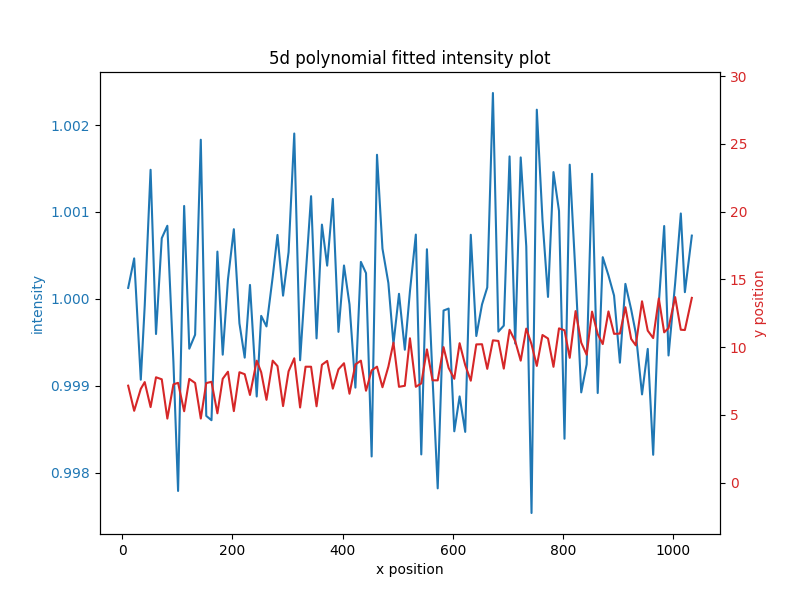

In [100]:
x_loc = masked_atoms[:, 1]
y_loc = masked_atoms[:, 0]
coeffs = np.polyfit(x_loc, sums, deg=5)
I_bg_poly = np.polyval(coeffs, x_loc)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(x_loc, sums/I_bg_poly, color='tab:blue', label='intensity')
ax1.set_xlabel('x position')
ax1.set_ylabel('intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc, color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ymin, ymax = y_loc.min(), y_loc.max()
ymin = ymin - (ymax-ymin)*0.95
ymax = ymax + (ymax-ymin)*0.95
ax2.set_ylim(ymin, ymax)

plt.title("5d polynomial fitted intensity plot")
plt.show()

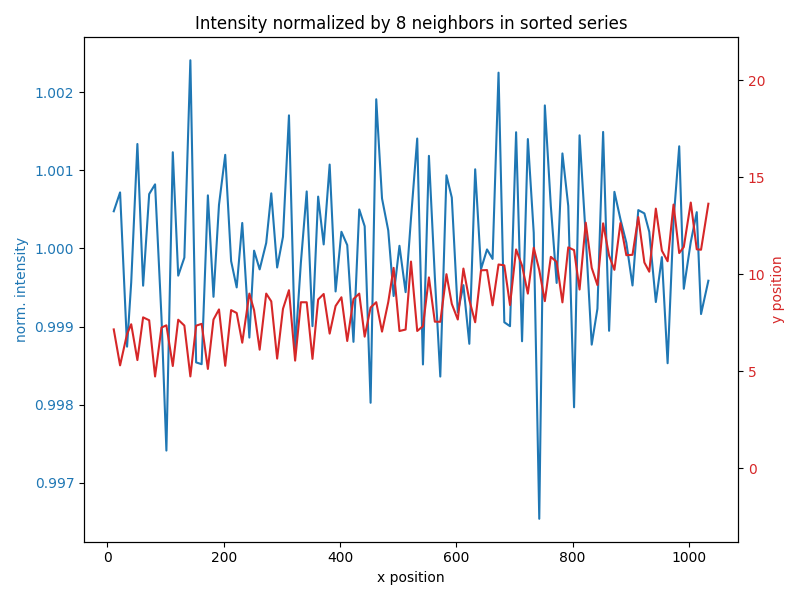

In [101]:
half = 4
N = len(sums)
norm_sums = np.empty(N)

for i in range(N):
    start = max(0, i - half)
    end   = min(N, i + half + 1)
    window = sums[start:end]

    rel_idx = i - start
    neigh_vals = np.delete(window, rel_idx)

    local_mean = neigh_vals.mean() if neigh_vals.size>0 else np.nan
    norm_sums[i] = sums[i] / local_mean

# now plot norm_sums vs x_loc alongside y_loc
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(x_loc, norm_sums,
         color='tab:blue', label='intensity (9-pt local norm)')
ax1.set_xlabel('x position')
ax1.set_ylabel('norm. intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc,
         color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# pad the y2 axis
ymin, ymax = y_loc.min(), y_loc.max()
ax2.set_ylim(ymin - 0.95*(ymax-ymin),
             ymax + 0.95*(ymax-ymin))

plt.title("Intensity normalized by 8 neighbors in sorted series")
fig.tight_layout()
plt.show()
